**This JupyterNotebook contains solution of Task 2 given by IIIT Delhi MIDAS LAB** 
* Framework : Tensorflow 2.2.0
* All the solutions are provided in TensorFlow Framework
* All the experiments are performed on GPU provided on Kaggle

**Part 1 - Designing of Model (NeilClassifierModel) for Custom Dataset 1 provided in the task sheet**
* Experimental Settings
                         1) Normalization- Scaling the image pixels from 0-255 to 0-1
                         2) Inverted the image color and making them same as the MNIST color scheme
                         3) Obtained the best performance of the model on 40x40 image size
                         4) Experimented with 128, 64, 32 and 28 also but 40x40 turned out to be the best.
                         5) batch_size = 16, learning_rate = 3x10^-3
                         6) Achieved Validation Accuracy : 86.48% (10% Validation Split)
                         7) Number of Parameters of Designed Model: Approximately 80k
                         8) Observations: BatchNorm and Dropout Helped in Faster Convergence and stabilising performance.
                         
**Part 2 - Dataset Used : MNIST and Custom Dataset 1**
* Experimental Observations and Methodology
                         1) Pretrained Model Tested : ResNet50, VGG16, MobileNet
                         2) Model With Random Weights : NeilClassifierModel
                         3) Learning Rate Used: 0.0001
                         
**Part 3 - Dataset Used : Custom Dataset 2**
* Experimental Observations and Methodology
                         1) Pretrained Model Tested : MobileNet
                         2) Model With Random Weights : NeilClassifierModel
                         3) Learning Rate Used: 0.0001
                         
**References**

*https://www.tensorflow.org/api_docs (This is the only reference which has been used while implementing)*

*@misc{ioffe2015batch,
      title={Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift}, 
      author={Sergey Ioffe and Christian Szegedy},
      year={2015},
      eprint={1502.03167},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}*

*Dropout: A Simple Way to Prevent Neural Networks from Overfitting*

# **Importing Required Libraries**

In [76]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AvgPool2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings 
import time
warnings.filterwarnings("ignore")

### **Setting the Directory Path to CustomDataset 1**

In [2]:
path = "../input/iiitdataset/trainPart1/train"

### **Defining the rescaling function**

In [3]:
normalisation_layer = layers.experimental.preprocessing.Rescaling(1./255.0)

### **Defining train generator which would iterate over the dataset and return batch of 16**
### **After that, images are normalised and inverted in color**

In [6]:
train_gen = tf.keras.preprocessing.image_dataset_from_directory(
    path, 
    validation_split = 0.1, 
    batch_size = 16, 
    image_size = (40,40),
    shuffle= True,
    seed = 24,
    subset = "training",
    color_mode= "grayscale"
)
norm_train_gen = train_gen.map(lambda x, y: (1-normalisation_layer(x), y))

Found 2480 files belonging to 62 classes.
Using 2232 files for training.


In [7]:
valid_gen = tf.keras.preprocessing.image_dataset_from_directory(
    path, 
    validation_split = 0.1, 
    batch_size = 16, 
    image_size = (40,40),
    shuffle= True,
    seed = 24,
    subset = "validation",
    color_mode= "grayscale"
)
norm_val_gen = valid_gen.map(lambda x, y: ((1-normalisation_layer(x)), y))

Found 2480 files belonging to 62 classes.
Using 248 files for validation.


In [9]:
x_sample,y_sample = next(iter(norm_val_gen))
print(x_sample.shape,y_sample.shape)

(16, 40, 40, 1) (16,)


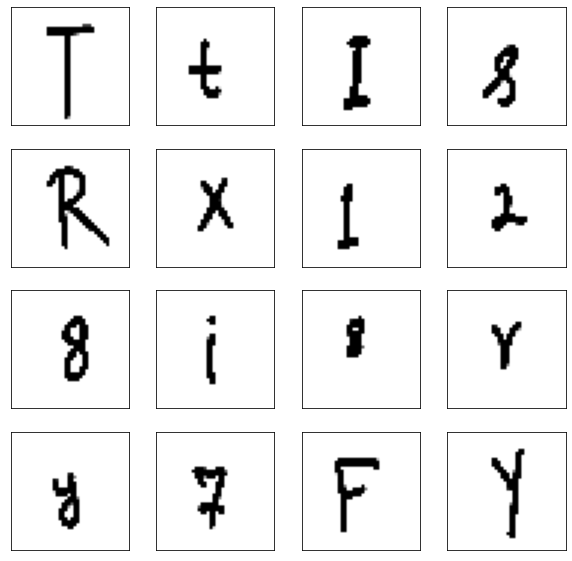

In [10]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(x_sample[i]), cmap=plt.cm.binary)
plt.show()

### **Defining NeilClassifierModel**

In [52]:
def NeilClassifierModel():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (5,5), strides = (1,1), activation = "relu", input_shape = (40,40,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3,3), strides = (1,1)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 32,kernel_size = (5,5),activation = "relu", strides = (1,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 64,kernel_size = (3,3),activation = "relu", strides = (1,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3,3), strides = (1,1)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 80,kernel_size = (3,3),activation = "relu", strides = (1,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))
    model.add(Dropout(0.3))
    model.add(AvgPool2D(pool_size = (3,3), strides = (1,1)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(62, activation = "softmax"))
    model.summary()
    return model

### **Defining function for Saving Model**

In [53]:
def save_model_weights(model, name):
    model.save_weights(name)

In [54]:
model = NeilClassifierModel()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 36, 36, 16)        416       
_________________________________________________________________
batch_normalization_50 (Batc (None, 36, 36, 16)        64        
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 34, 34, 16)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 30, 30, 32)        12832     
_________________________________________________________________
batch_normalization_51 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 32)      

In [55]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"])
history_one = model.fit_generator(generator = norm_train_gen, validation_data = norm_val_gen,epochs = 30)

Epoch 1/30
140/140 [==============================] - 34s 223ms/step - loss: 4.3941 - acc: 0.0165 - val_loss: 5.0307 - val_acc: 0.0242
Epoch 2/30
140/140 [==============================] - 33s 222ms/step - loss: 3.7348 - acc: 0.0922 - val_loss: 4.7219 - val_acc: 0.0121
Epoch 3/30
140/140 [==============================] - 32s 221ms/step - loss: 2.9817 - acc: 0.2114 - val_loss: 4.2104 - val_acc: 0.0323
Epoch 4/30
140/140 [==============================] - 33s 221ms/step - loss: 2.3910 - acc: 0.3142 - val_loss: 2.9641 - val_acc: 0.1653
Epoch 5/30
140/140 [==============================] - 32s 220ms/step - loss: 1.9120 - acc: 0.4347 - val_loss: 1.7433 - val_acc: 0.4798
Epoch 6/30
140/140 [==============================] - 32s 220ms/step - loss: 1.6480 - acc: 0.4897 - val_loss: 1.5198 - val_acc: 0.5444
Epoch 7/30
140/140 [==============================] - 32s 220ms/step - loss: 1.4384 - acc: 0.5510 - val_loss: 1.4545 - val_acc: 0.5726
Epoch 8/30
140/140 [==============================] - 3

In [56]:
save_model_weights(model,"part_1_checkpoint")

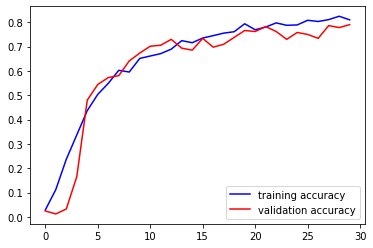

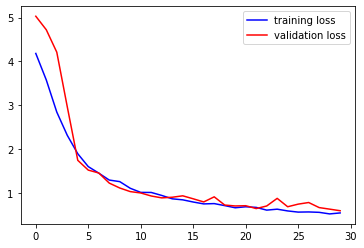

In [57]:
plt.plot(history_one.history["acc"], label = "training accuracy", color = "blue")
plt.plot(history_one.history["val_acc"], label = "validation accuracy", color= "red")
plt.legend()
plt.show()

plt.plot(history_one.history["loss"], label = "training loss", color = "blue")
plt.plot(history_one.history["val_loss"], label = "validation loss", color= "red")
plt.legend()
plt.show()

In [58]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"])
history_one_1 = model.fit_generator(generator = norm_train_gen, validation_data = norm_val_gen,epochs = 15)

Epoch 1/15
140/140 [==============================] - 34s 220ms/step - loss: 0.4765 - acc: 0.8468 - val_loss: 0.5061 - val_acc: 0.8145
Epoch 2/15
140/140 [==============================] - 32s 218ms/step - loss: 0.3861 - acc: 0.8627 - val_loss: 0.5291 - val_acc: 0.8105
Epoch 3/15
140/140 [==============================] - 33s 221ms/step - loss: 0.4119 - acc: 0.8526 - val_loss: 0.6029 - val_acc: 0.7823
Epoch 4/15
140/140 [==============================] - 33s 223ms/step - loss: 0.4023 - acc: 0.8616 - val_loss: 0.5774 - val_acc: 0.7782
Epoch 5/15
140/140 [==============================] - 32s 221ms/step - loss: 0.4218 - acc: 0.8558 - val_loss: 0.5450 - val_acc: 0.8105
Epoch 6/15
140/140 [==============================] - 33s 222ms/step - loss: 0.3922 - acc: 0.8664 - val_loss: 0.5210 - val_acc: 0.8226
Epoch 7/15
140/140 [==============================] - 32s 220ms/step - loss: 0.4231 - acc: 0.8578 - val_loss: 0.5556 - val_acc: 0.8024
Epoch 8/15
140/140 [==============================] - 3

In [59]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"])
history_one_1 = model.fit_generator(generator = norm_train_gen, validation_data = norm_val_gen,epochs = 25)

Epoch 1/25
140/140 [==============================] - 34s 224ms/step - loss: 0.3050 - acc: 0.8977 - val_loss: 0.4683 - val_acc: 0.8347
Epoch 2/25
140/140 [==============================] - 32s 220ms/step - loss: 0.2958 - acc: 0.8994 - val_loss: 0.4705 - val_acc: 0.8266
Epoch 3/25
140/140 [==============================] - 33s 222ms/step - loss: 0.2461 - acc: 0.9248 - val_loss: 0.4634 - val_acc: 0.8306
Epoch 4/25
140/140 [==============================] - 33s 223ms/step - loss: 0.3058 - acc: 0.8996 - val_loss: 0.4707 - val_acc: 0.8105
Epoch 5/25
140/140 [==============================] - 32s 221ms/step - loss: 0.2551 - acc: 0.9158 - val_loss: 0.4719 - val_acc: 0.8145
Epoch 6/25
140/140 [==============================] - 32s 220ms/step - loss: 0.2802 - acc: 0.9115 - val_loss: 0.4753 - val_acc: 0.8306
Epoch 7/25
140/140 [==============================] - 32s 219ms/step - loss: 0.2889 - acc: 0.9029 - val_loss: 0.4666 - val_acc: 0.8266
Epoch 8/25
140/140 [==============================] - 3

In [64]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.00008, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"])
history_one_1 = model.fit_generator(generator = norm_train_gen, validation_data = norm_val_gen,epochs = 10)

Epoch 1/10
140/140 [==============================] - 34s 223ms/step - loss: 0.2183 - acc: 0.9276 - val_loss: 0.5310 - val_acc: 0.8065
Epoch 2/10
140/140 [==============================] - 33s 222ms/step - loss: 0.2065 - acc: 0.9311 - val_loss: 0.5340 - val_acc: 0.8065
Epoch 3/10
140/140 [==============================] - 33s 223ms/step - loss: 0.1923 - acc: 0.9355 - val_loss: 0.5303 - val_acc: 0.8145
Epoch 4/10
140/140 [==============================] - 33s 224ms/step - loss: 0.1881 - acc: 0.9390 - val_loss: 0.5272 - val_acc: 0.8387
Epoch 5/10
140/140 [==============================] - 33s 222ms/step - loss: 0.1885 - acc: 0.9360 - val_loss: 0.5243 - val_acc: 0.8266
Epoch 6/10
140/140 [==============================] - 33s 223ms/step - loss: 0.2003 - acc: 0.9329 - val_loss: 0.5285 - val_acc: 0.8226
Epoch 7/10
140/140 [==============================] - 33s 222ms/step - loss: 0.1806 - acc: 0.9382 - val_loss: 0.5208 - val_acc: 0.8266
Epoch 8/10
140/140 [==============================] - 3

In [65]:
save_model_weights(model,"part_1_checkpoint")

# Part 2  

### **Three analysis have been done in Part 2**
**I will be explaining it stepwise** 

**1. At the first step the MNIST Data is Loaded and Reshaped to size 40x40 with 1 channel after Normalising the Images to 0-1**

**2. Now, we will train the NeilClassifierModel (Random Weights) on the MNIST Dataset and compare the performance**

**3. Now, we will also train the NeilClassifierModel (Pretrained on CustomDataset1 (0-9)) on MNIST**

**4. Next thing, we will also train the Pretrained Model (MobileNet, ResNet50, VGG16) on MNIST**

### **Loading the MNIST Dataset**

In [91]:
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

### **Checking the splitwise shapes**

In [92]:
print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### **Reshaping the images to 28x28x1**

In [93]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [94]:
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### **Rescaling the image's pixels between 0-1**

In [95]:
x_train_ = x_train/255.0
x_test_ = x_test/255.0

### **Defining resizing function for 40x40**

In [96]:
resizing = tf.keras.layers.experimental.preprocessing.Resizing(40,40)

In [97]:
x_train_ = resizing(x_train_)
x_test_ = resizing(x_test_)

### **Training and Evaluting Performance of NeilClassifierModel on MNIST Dataset starting with Random Weights**

In [98]:
def NeilClassifierModel1():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (5,5), strides = (1,1), activation = "relu", input_shape = (40,40,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3,3), strides = (1,1)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 32,kernel_size = (5,5),activation = "relu", strides = (1,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 64,kernel_size = (3,3),activation = "relu", strides = (1,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3,3), strides = (1,1)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters = 80,kernel_size = (3,3),activation = "relu", strides = (1,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))
    model.add(Dropout(0.3))
    model.add(AvgPool2D(pool_size = (3,3), strides = (1,1)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(10, activation = "softmax"))
    model.summary()
    return model
model = NeilClassifierModel1()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 36, 36, 16)        416       
_________________________________________________________________
batch_normalization_78 (Batc (None, 36, 36, 16)        64        
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 34, 34, 16)        0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 30, 30, 32)        12832     
_________________________________________________________________
batch_normalization_79 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 14, 14, 32)      

### **Training on MNIST Data**

In [99]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"])
start_time = time.time()
history_two = model.fit(x = x_train_,y = y_train, validation_data = (x_test_,y_test),epochs = 30,batch_size = 256)
end_time = time.time()

Epoch 1/30
235/235 [==============================] - 5s 17ms/step - loss: 1.6430 - acc: 0.5124 - val_loss: 4.8064 - val_acc: 0.1135
Epoch 2/30
235/235 [==============================] - 4s 16ms/step - loss: 0.2848 - acc: 0.9137 - val_loss: 1.7387 - val_acc: 0.4060
Epoch 3/30
235/235 [==============================] - 4s 16ms/step - loss: 0.1735 - acc: 0.9470 - val_loss: 0.1925 - val_acc: 0.9468
Epoch 4/30
235/235 [==============================] - 4s 16ms/step - loss: 0.1300 - acc: 0.9609 - val_loss: 0.0947 - val_acc: 0.9739
Epoch 5/30
235/235 [==============================] - 4s 17ms/step - loss: 0.1109 - acc: 0.9671 - val_loss: 0.0707 - val_acc: 0.9805
Epoch 6/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0976 - acc: 0.9707 - val_loss: 0.0660 - val_acc: 0.9814
Epoch 7/30
235/235 [==============================] - 4s 16ms/step - loss: 0.0847 - acc: 0.9744 - val_loss: 0.0625 - val_acc: 0.9815
Epoch 8/30
235/235 [==============================] - 4s 16ms/step - 

In [100]:
print("Training Time : {}".format(end_time-start_time))

Training Time : 115.20717692375183


### **Plotting Training and Validation Curve for NeilClassifierModel on MNIST initialized with Random Weights**

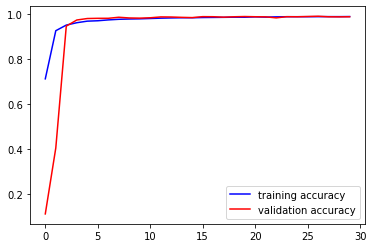

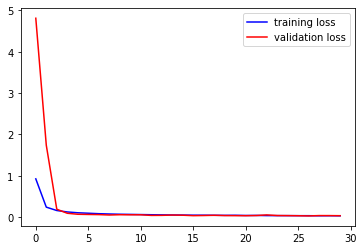

In [101]:
plt.plot(history_two.history["acc"], label = "training accuracy", color = "blue")
plt.plot(history_two.history["val_acc"], label = "validation accuracy", color= "red")
plt.legend()
plt.show()

plt.plot(history_two.history["loss"], label = "training loss", color = "blue")
plt.plot(history_two.history["val_loss"], label = "validation loss", color= "red")
plt.legend()
plt.show()

### **Setting the path for Custom Dataset 1 which was provided for only 0-9 class and training NeilClassifierModel on that and checking training performance on MNIST with learned weights**

In [102]:
path = "../input/custommnist/CustomMNISTCustomDataset1"
normalisation_layer = layers.experimental.preprocessing.Rescaling(1./255.0)

In [103]:
train_gen = tf.keras.preprocessing.image_dataset_from_directory(
    path, 
    validation_split = 0.1, 
    batch_size = 16, 
    image_size = (40,40),
    seed = 24,
    subset = "training",
    color_mode= "grayscale"
)
norm_train_gen = train_gen.map(lambda x, y: (1-normalisation_layer(x), y))

valid_gen = tf.keras.preprocessing.image_dataset_from_directory(
    path, 
    validation_split = 0.1, 
    batch_size = 16, 
    image_size = (40,40),
    seed = 24,
    subset = "validation",
    color_mode= "grayscale"
)
norm_val_gen = valid_gen.map(lambda x, y: ((1-normalisation_layer(x)), y))

Found 400 files belonging to 10 classes.
Using 360 files for training.
Found 400 files belonging to 10 classes.
Using 40 files for validation.


In [104]:
model = NeilClassifierModel1()
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"])
start_time = time.time()
history_1 = model.fit_generator(generator = norm_train_gen, validation_data = norm_val_gen,epochs = 90)
end_time_time = time.time()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 36, 36, 16)        416       
_________________________________________________________________
batch_normalization_82 (Batc (None, 36, 36, 16)        64        
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 34, 34, 16)        0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 30, 30, 32)        12832     
_________________________________________________________________
batch_normalization_83 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 14, 14, 32)      

In [108]:
print("Training Time : {}".format(end_time_time-start_time))

Training Time : 479.0675163269043


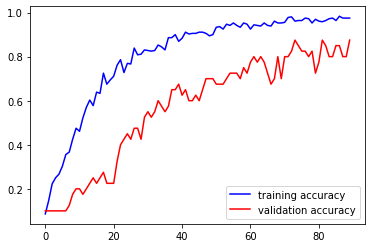

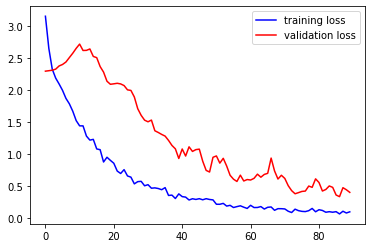

In [109]:
plt.plot(history_1.history["acc"], label = "training accuracy", color = "blue")
plt.plot(history_1.history["val_acc"], label = "validation accuracy", color= "red")
plt.legend()
plt.show()

plt.plot(history_1.history["loss"], label = "training loss", color = "blue")
plt.plot(history_1.history["val_loss"], label = "validation loss", color= "red")
plt.legend()
plt.show()

### **Fine-Tuning NeilClassifierModel1 on MNIST**

In [110]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"])
time_1 = time.time()
history_2 = model.fit(x = x_train_,y = y_train, validation_data = (x_test_,y_test),epochs = 15,batch_size = 256)
time_2 = time.time()

Epoch 1/15
235/235 [==============================] - 5s 18ms/step - loss: 0.5652 - acc: 0.8362 - val_loss: 0.2012 - val_acc: 0.9394
Epoch 2/15
235/235 [==============================] - 4s 16ms/step - loss: 0.1721 - acc: 0.9484 - val_loss: 0.1027 - val_acc: 0.9712
Epoch 3/15
235/235 [==============================] - 4s 16ms/step - loss: 0.1259 - acc: 0.9610 - val_loss: 0.0882 - val_acc: 0.9752
Epoch 4/15
235/235 [==============================] - 4s 17ms/step - loss: 0.1044 - acc: 0.9685 - val_loss: 0.0744 - val_acc: 0.9794
Epoch 5/15
235/235 [==============================] - 4s 16ms/step - loss: 0.0830 - acc: 0.9745 - val_loss: 0.0576 - val_acc: 0.9836
Epoch 6/15
235/235 [==============================] - 4s 16ms/step - loss: 0.0810 - acc: 0.9750 - val_loss: 0.0547 - val_acc: 0.9842
Epoch 7/15
235/235 [==============================] - 4s 16ms/step - loss: 0.0722 - acc: 0.9779 - val_loss: 0.0576 - val_acc: 0.9828
Epoch 8/15
235/235 [==============================] - 4s 16ms/step - 

In [111]:
print("Fine_tuning Time : {}".format(time_2-time_1))

Fine_tuning Time : 58.38091492652893


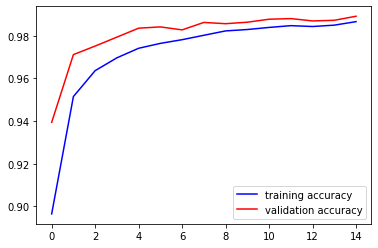

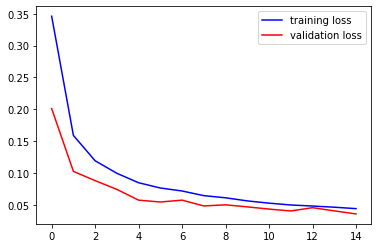

In [112]:
plt.plot(history_2.history["acc"], label = "training accuracy", color = "blue")
plt.plot(history_2.history["val_acc"], label = "validation accuracy", color= "red")
plt.legend()
plt.show()

plt.plot(history_2.history["loss"], label = "training loss", color = "blue")
plt.plot(history_2.history["val_loss"], label = "validation loss", color= "red")
plt.legend()
plt.show()

### **Defining Pretrained (MobileNet, VGG16, ResNet50) Models for MNIST Dataset**

In [113]:
class pretrained_model_mobilenet(tf.keras.Model):
    def __init__(self):
        super(pretrained_model_mobilenet, self).__init__()
        self.pretrained_mobilenet = tf.keras.applications.MobileNet(include_top = False,weights = "imagenet", input_shape = (40,40,3))
#         for layer in self.pretrained_mobilenet.layers:
#             layer.trainable = False
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation = "relu")
        self.dense2 = Dense(128, activation = "relu")
        self.dense3 = Dense(10, activation = "softmax")
    def call(self,x):
        x = tf.repeat(x, 3, -1)
        x = self.pretrained_mobilenet(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [114]:
pre_model_mobilenet = pretrained_model_mobilenet()

pre_model_mobilenet.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"] )


17227776/17225924 [==============================] - 1s 0us/step


In [116]:
time_1 = time.time()
history_three = pre_model_mobilenet.fit(x = x_train_,y = y_train, validation_data = (x_test_,y_test), epochs = 10, batch_size = 256)
time_2 = time.time()

Epoch 1/10
235/235 [==============================] - 12s 34ms/step - loss: 1.4314 - acc: 0.5415 - val_loss: 1.4504 - val_acc: 0.6419
Epoch 2/10
235/235 [==============================] - 7s 30ms/step - loss: 0.1834 - acc: 0.9460 - val_loss: 0.2704 - val_acc: 0.9224
Epoch 3/10
235/235 [==============================] - 7s 30ms/step - loss: 0.0815 - acc: 0.9755 - val_loss: 0.1020 - val_acc: 0.9684
Epoch 4/10
235/235 [==============================] - 7s 31ms/step - loss: 0.0419 - acc: 0.9873 - val_loss: 0.0889 - val_acc: 0.9724
Epoch 5/10
235/235 [==============================] - 7s 30ms/step - loss: 0.0285 - acc: 0.9917 - val_loss: 0.0845 - val_acc: 0.9755
Epoch 6/10
235/235 [==============================] - 7s 30ms/step - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0749 - val_acc: 0.9789
Epoch 7/10
235/235 [==============================] - 7s 30ms/step - loss: 0.0104 - acc: 0.9971 - val_loss: 0.0769 - val_acc: 0.9786
Epoch 8/10
235/235 [==============================] - 7s 31ms/step -

In [117]:
print("Fine_tuning Time : {}".format(time_2-time_1))

Fine_tuning Time : 75.88210010528564


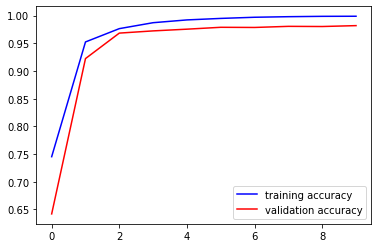

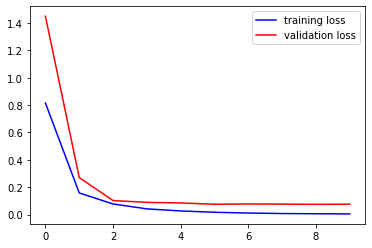

In [118]:
plt.plot(history_three.history["acc"], label = "training accuracy", color = "blue")
plt.plot(history_three.history["val_acc"], label = "validation accuracy", color= "red")
plt.legend()
plt.show()

plt.plot(history_three.history["loss"], label = "training loss", color = "blue")
plt.plot(history_three.history["val_loss"], label = "validation loss", color= "red")
plt.legend()
plt.show()

In [119]:
class pretrained_model_vgg(tf.keras.Model):
    def __init__(self):
        super(pretrained_model_vgg, self).__init__()
        self.pretrained_vgg16 = tf.keras.applications.VGG16(include_top = False,weights = "imagenet", input_shape = (40,40,3))
#         for layer in self.pretrained_vgg16.layers:
#             layer.trainable = False
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation = "relu")
        self.dense2 = Dense(128, activation = "relu")
        self.dense3 = Dense(10, activation = "softmax")
    def call(self,x):
        x = tf.repeat(x, 3, -1)
        x = self.pretrained_vgg16(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [120]:
model_vgg = pretrained_model_vgg()

58892288/58889256 [==============================] - 1s 0us/step


In [121]:
model_vgg.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"] )

In [122]:
time_1 = time.time()
history_four = model_vgg.fit(x = x_train_,y = y_train, validation_data = (x_test_,y_test), epochs = 10, batch_size = 256)
time_2 = time.time()

Epoch 1/10
235/235 [==============================] - 24s 92ms/step - loss: 0.4587 - acc: 0.8580 - val_loss: 0.0432 - val_acc: 0.9864
Epoch 2/10
235/235 [==============================] - 21s 88ms/step - loss: 0.0303 - acc: 0.9909 - val_loss: 0.0237 - val_acc: 0.9929
Epoch 3/10
235/235 [==============================] - 21s 88ms/step - loss: 0.0183 - acc: 0.9944 - val_loss: 0.0310 - val_acc: 0.9898
Epoch 4/10
235/235 [==============================] - 21s 88ms/step - loss: 0.0149 - acc: 0.9948 - val_loss: 0.0172 - val_acc: 0.9938
Epoch 5/10
235/235 [==============================] - 21s 88ms/step - loss: 0.0130 - acc: 0.9961 - val_loss: 0.0197 - val_acc: 0.9935
Epoch 6/10
235/235 [==============================] - 21s 88ms/step - loss: 0.0101 - acc: 0.9972 - val_loss: 0.0209 - val_acc: 0.9933
Epoch 7/10
235/235 [==============================] - 21s 88ms/step - loss: 0.0108 - acc: 0.9968 - val_loss: 0.0276 - val_acc: 0.9920
Epoch 8/10
235/235 [==============================] - 21s 88ms

In [123]:
print("Fine_tuning Time : {}".format(time_2-time_1))

Fine_tuning Time : 209.39139342308044


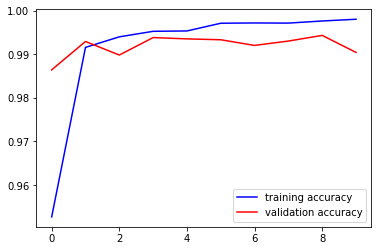

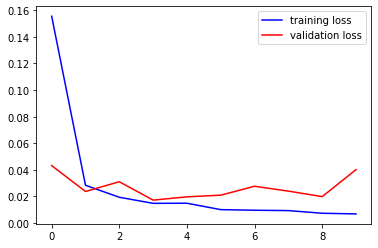

In [124]:
plt.plot(history_four.history["acc"], label = "training accuracy", color = "blue")
plt.plot(history_four.history["val_acc"], label = "validation accuracy", color= "red")
plt.legend()
plt.show()

plt.plot(history_four.history["loss"], label = "training loss", color = "blue")
plt.plot(history_four.history["val_loss"], label = "validation loss", color= "red")
plt.legend()
plt.show()

In [125]:
class pretrained_model_resnet(tf.keras.Model):
    def __init__(self):
        super(pretrained_model_resnet, self).__init__()
        self.pretrained_resnet = tf.keras.applications.ResNet50(include_top = False,weights = "imagenet", input_shape = (40,40,3))
#         for layer in self.pretrained_vgg16.layers:
#             layer.trainable = False
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation = "relu")
        self.dense2 = Dense(128, activation = "relu")
        self.dense3 = Dense(10, activation = "softmax")
    def call(self,x):
        x = tf.repeat(x, 3, -1)
        x = self.pretrained_resnet(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [126]:
model_resnet = pretrained_model_resnet()

94773248/94765736 [==============================] - 1s 0us/step


In [127]:
model_resnet.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"] )

In [128]:
time_1 = time.time()
history_fifth = model_resnet.fit(x = x_train_,y = y_train, validation_data = (x_test_,y_test), epochs = 10, batch_size = 256)
time_2 = time.time()

Epoch 1/10
235/235 [==============================] - 34s 117ms/step - loss: 1.5664 - acc: 0.5043 - val_loss: 11.2756 - val_acc: 0.1218
Epoch 2/10
235/235 [==============================] - 26s 110ms/step - loss: 0.1892 - acc: 0.9440 - val_loss: 16.3597 - val_acc: 0.1305
Epoch 3/10
235/235 [==============================] - 26s 110ms/step - loss: 0.0759 - acc: 0.9786 - val_loss: 3.6627 - val_acc: 0.2276
Epoch 4/10
235/235 [==============================] - 26s 110ms/step - loss: 0.0337 - acc: 0.9915 - val_loss: 1.2296 - val_acc: 0.6336
Epoch 5/10
235/235 [==============================] - 26s 110ms/step - loss: 0.0173 - acc: 0.9964 - val_loss: 0.3617 - val_acc: 0.8864
Epoch 6/10
235/235 [==============================] - 26s 110ms/step - loss: 0.0099 - acc: 0.9984 - val_loss: 0.2259 - val_acc: 0.9344
Epoch 7/10
235/235 [==============================] - 26s 110ms/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.1317 - val_acc: 0.9622
Epoch 8/10
235/235 [==============================] -

In [129]:
print("Fine_tuning Time : {}".format(time_2-time_1))

Fine_tuning Time : 267.06080508232117


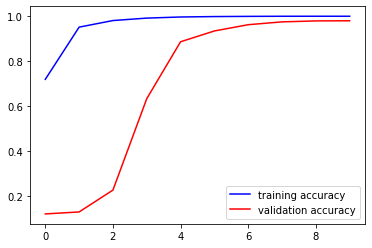

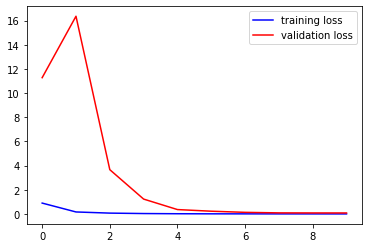

In [130]:
plt.plot(history_fifth.history["acc"], label = "training accuracy", color = "blue")
plt.plot(history_fifth.history["val_acc"], label = "validation accuracy", color= "red")
plt.legend()
plt.show()

plt.plot(history_fifth.history["loss"], label = "training loss", color = "blue")
plt.plot(history_fifth.history["val_loss"], label = "validation loss", color= "red")
plt.legend()
plt.show()

## **Part 3**

### **Defining Path to CustomDataset 2 (MNIST)**

In [131]:
path = "../input/iiitdataset/mnistTask3/mnistTask"
normalisation_layer = layers.experimental.preprocessing.Rescaling(1./255.0)
class_label = ["0", "1", "2", "3","4", "5", "6", "7", "8", "9"]

In [132]:
train_gen = tf.keras.preprocessing.image_dataset_from_directory(
    path, 
    validation_split = 0.15, 
    batch_size = 256, 
    image_size = (40,40),
    seed = 24,
    subset = "training",
    color_mode= "grayscale"
)
norm_train_gen = train_gen.map(lambda x, y: (normalisation_layer(x), y))

valid_gen = tf.keras.preprocessing.image_dataset_from_directory(
    path, 
    validation_split = 0.15, 
    batch_size = 256, 
    image_size = (40,40),
    seed = 24,
    subset = "validation",
    color_mode= "grayscale"
)
norm_val_gen = valid_gen.map(lambda x, y: (normalisation_layer(x), y))

Found 60000 files belonging to 10 classes.
Using 51000 files for training.
Found 60000 files belonging to 10 classes.
Using 9000 files for validation.


### **Samples from the Custom MNIST Dataset 2**

In [133]:
x_sample ,y_sample = next(iter(norm_train_gen))
print(x_sample.shape, y_sample.shape)

(256, 40, 40, 1) (256,)


### **As we are observing in the cell given below that each class contains samples from other classes which will lead the model to train on wrong samples**

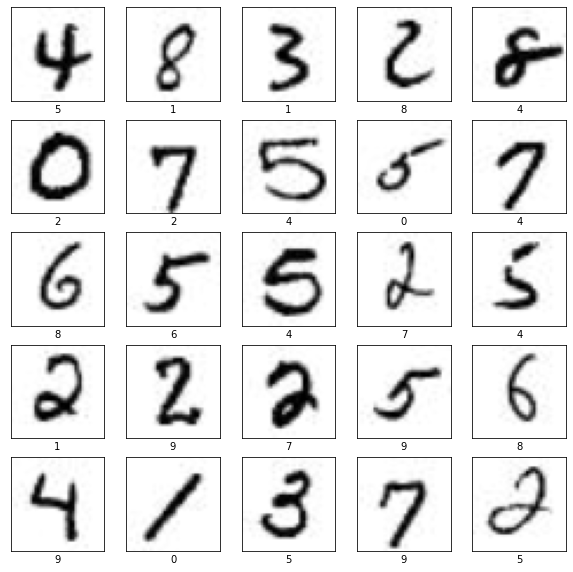

In [134]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(x_sample[i]), cmap=plt.cm.binary)
    plt.xlabel(class_label[y_sample[i]])
plt.show()

### **Defining and Trainin NeilClassifierModel on Custom Dataset 2 (MNIST)**

In [136]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), activation = "relu", input_shape = (40,40,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3), strides = (1,1)))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 32,kernel_size = (3,3),activation = "relu", strides = (1,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 64,kernel_size = (3,3),activation = "relu", strides = (1,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3), strides = (1,1)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 80,kernel_size = (3,3),activation = "relu", strides = (1,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3,3), strides = (2,2)))
model.add(Dropout(0.2))
model.add(AvgPool2D(pool_size = (4,4), strides = (1,1)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation = "relu"))
model.add(Dense(10, activation = "softmax"))
model.summary()
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"])
history_1 = model.fit_generator(generator = norm_train_gen, validation_data = norm_val_gen,epochs = 10)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 38, 38, 16)        160       
_________________________________________________________________
batch_normalization_90 (Batc (None, 38, 38, 16)        64        
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
dropout_102 (Dropout)        (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 34, 34, 32)        4640      
_________________________________________________________________
batch_normalization_91 (Batc (None, 34, 34, 32)        128       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 16, 16, 32)      

### **Evaluating Accuracy of NeilClassifierModel trained on CustomDataset 2(MNIST)  on Test Split of Original MNIST Dataset**

In [137]:
model.evaluate(x_test_,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 4.5207 - acc: 0.0019


[4.520742416381836, 0.0019000000320374966]

### **Defining and Training pretrained MobileNet**

In [138]:
class pretrained_model_mobilenet(tf.keras.Model):
    def __init__(self):
        super(pretrained_model_mobilenet, self).__init__()
        self.pretrained_mobilenet = tf.keras.applications.MobileNet(include_top = False,weights = "imagenet", input_shape = (40,40,3))
#         for layer in self.pretrained_mobilenet.layers:
#             layer.trainable = False
        self.flatten = Flatten()
        self.dense1 = Dense(256, activation = "relu")
        self.dense2 = Dense(128, activation = "relu")
        self.dense3 = Dense(10, activation = "softmax")
    def call(self,x):
        x = tf.repeat(x, 3, -1)
        x = self.pretrained_mobilenet(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [139]:
pre_model_mobilenet = pretrained_model_mobilenet()
pre_model_mobilenet.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07), metrics = ["acc"] )

In [140]:
history_three = pre_model_mobilenet.fit(norm_train_gen, validation_data = norm_val_gen, epochs = 5, batch_size = 256)

Epoch 1/5
200/200 [==============================] - 40s 181ms/step - loss: 2.6418 - acc: 0.1046 - val_loss: 2.3194 - val_acc: 0.1009
Epoch 2/5
200/200 [==============================] - 35s 171ms/step - loss: 2.3436 - acc: 0.1240 - val_loss: 2.3541 - val_acc: 0.1019
Epoch 3/5
200/200 [==============================] - 35s 171ms/step - loss: 2.2765 - acc: 0.1440 - val_loss: 2.3484 - val_acc: 0.1036
Epoch 4/5
200/200 [==============================] - 35s 170ms/step - loss: 2.2388 - acc: 0.1612 - val_loss: 2.3449 - val_acc: 0.1088
Epoch 5/5
200/200 [==============================] - 35s 170ms/step - loss: 2.1990 - acc: 0.1802 - val_loss: 2.3432 - val_acc: 0.1146


In [141]:
pre_model_mobilenet.evaluate(x_test_,y_test)

313/313 [==============================] - 3s 7ms/step - loss: 3.0908 - acc: 0.0204


[3.0908002853393555, 0.020400000736117363]